### Dataset splitting according to pixel features

Seelect training dataset from the whole dataset.

- Split and extract training dataset according to pixel features such as color, texture and entropy.
- A copy of selected training dataset will be made.
- A summary of the splitting result is stored as CSV file with columns: ['img_filepath', 'img_cluster', 'train']

Sources -

[1] https://github.com/easz/urban-tree/blob/main/urbantree/detectree/preprocessing.py   
[2] https://github.com/martibosch/detectree-example/blob/master/notebooks/background.ipynb   
[3] https://detectree.readthedocs.io/en/latest/train_test_split.html  
[4] https://www.javatpoint.com/k-means-clustering-algorithm-in-machine-learning

In [ ]:
!pip install pydantic
!pip install detectree
!pip install shapely

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from detectree import filters, image_descriptor, pixel_features
import numpy as np

In [ ]:
'''
import pandas as pd

# Load the CSV file into a DataFrame
csv_path = '/Users/admin/Documents/Masters 1st semester/Machine learning/project/22resampled/meta.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_path)

# Replace the substring in the 'image_path' column
df['img_filepath'] = df['img_filepath'].str.replace('/home/012328706/257Tree/', '/Users/admin/Documents/Masters 1st semester/Machine learning/project/')

# Save the modified DataFrame back to the CSV file
df.to_csv('/Users/admin/Documents/Masters 1st semester/Machine learning/project/22resampled/meta.csv', index=False)  # Replace with the desired output path

print(df.head())
'''

"\nimport pandas as pd\n\n# Load the CSV file into a DataFrame\ncsv_path = '/Users/admin/Documents/Masters 1st semester/Machine learning/project/22resampled/meta.csv'  # Replace with the actual path to your CSV file\ndf = pd.read_csv(csv_path)\n\n# Replace the substring in the 'image_path' column\ndf['img_filepath'] = df['img_filepath'].str.replace('/home/012328706/257Tree/', '/Users/admin/Documents/Masters 1st semester/Machine learning/project/')\n\n# Save the modified DataFrame back to the CSV file\ndf.to_csv('/Users/admin/Documents/Masters 1st semester/Machine learning/project/22resampled/meta.csv', index=False)  # Replace with the desired output path\n\nprint(df.head())\n"

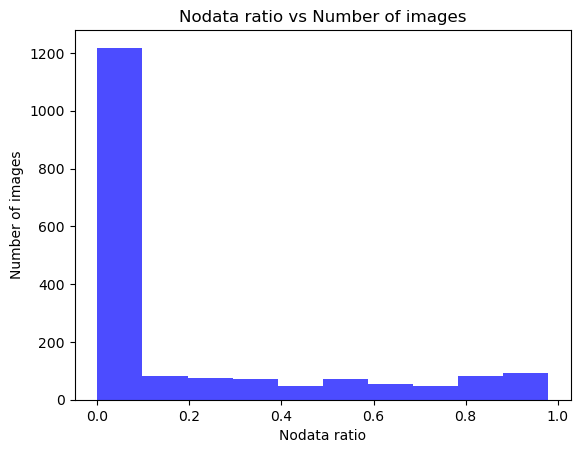

Number of values below 0.3: 1375


In [ ]:
# Exploratory data analysis of 22 imagery
year = 22
resampled_path = f'{year}resampled/'
df = pd.read_csv(resampled_path + 'meta.csv')

# Create a histogram
plt.hist(df['nodata'], bins = 10, color='blue', alpha=0.7)

#custom_xticks = np.arange(0.0, 1.1, 0.1)
#plt.xticks(custom_xticks)

# Customize the plot
plt.title('Nodata ratio vs Number of images')
plt.xlabel('Nodata ratio')
plt.ylabel('Number of images')

# Save the histogram plot as an image file (e.g., PNG or PDF)
plt.savefig('histogram_plot_nodata.png')

# Display the plot
plt.show()

# Count the number of values below 0.3
count_below_thres = (df['nodata'] <= 0.3).sum()

# Print the result
print(f"Number of values below 0.3: {count_below_thres}")

In [ ]:
# gist descriptors - (each image)  [2]
img_filepath = image_path[10]

kernels = filters.get_gabor_filter_bank(frequencies=(.1, .25, .4),
                                        num_orientations=(4, 8, 8))
response_bins_per_axis = 4
num_color_bins = 8

img_descr = image_descriptor.compute_image_descriptor_from_filepath(
    img_filepath,
    kernels=kernels,
    response_bins_per_axis=response_bins_per_axis,
    num_color_bins=num_color_bins)

In [ ]:
img_descr.shape

(832,)

Split and extract training dataset according to pixel features such as color, texture and entropy.
Selected training dataset will be copied to `dataset_train_dir` and the summary of the result is stored as CSV file with columns: ['img_filepath', 'img_cluster', 'train']


In [ ]:
# define all variables
# (use '0' to train images without any nodata. use '1' to train all possible images)
dataset_split_max_nodata_threshold = 0.3               # 0.3
dataset_split_nr_clusters =          2                 # 2
dataset_split_nr_pca_comp =          64                # 64
dataset_split_train_proportion =     0.02              # 2% of dataset

# input
dataset_img_path_list = "22resampled/output/"
dataset_img_meta_path = "22resampled/meta.csv"

dataset_name = 'sanjose_urbantree'
profile_name = 'deepforest_r1'

# output
dataset_split_meta_path = f'interim/{dataset_name}/{profile_name}/meta/meta_2.csv'
dataset_train_dir = f'interim/{dataset_name}/{profile_name}/train_2/'

In [ ]:
# dataset split method - [1]
# "train_test_split" [3] from DetecTree library.

import os
import pandas as pd
from pathlib import Path
import shutil
import detectree


################### Constants ###########################


assert dataset_img_meta_path, "Path is not defined"
assert dataset_img_path_list, "Path is not defined"

DATASET_IMG_META_PATH  = Path(dataset_img_meta_path)
MAX_NODATA_THRESHOLD   = dataset_split_max_nodata_threshold
DATASET_IMG_PATH_LIST  = dataset_img_path_list
TRAIN_SPLIT_META_PATH =  dataset_split_meta_path
DATASET_TRAIN_DIR = dataset_train_dir

  # use default "cluster-II" method
  # we can still decide to use Cluter-I or Cluster-II methods during training
NR_SPLIT_CLUSTERS = dataset_split_nr_clusters
NR_PCA_COMPONENTS = dataset_split_nr_pca_comp
TRAIN_PROPOTION   = dataset_split_train_proportion


  ##########################################################

  # reset folders
os.makedirs(Path(TRAIN_SPLIT_META_PATH).parent, exist_ok=True)
os.makedirs(DATASET_TRAIN_DIR, exist_ok=True)

  ## prepare source images to process
if DATASET_IMG_META_PATH:
    meta_df = pd.read_csv(DATASET_IMG_META_PATH)
    threshold_filter = meta_df['nodata'] <= MAX_NODATA_THRESHOLD
    selected_img_filepaths   = meta_df[threshold_filter]['img_filepath'].tolist()
    unselected_img_filepaths = meta_df[~threshold_filter]['img_filepath'].tolist()
else:
    selected_img_filepaths = DATASET_IMG_PATH_LIST
    unselected_img_filepaths = []

if len(selected_img_filepaths) == 0:
    raise RuntimeError("No file is available to be training data.")

print(f"Number of principal components - {NR_PCA_COMPONENTS}")
print(f'Number of 1st level clusters - {NR_SPLIT_CLUSTERS}')
print(f'Train Propotion - {TRAIN_PROPOTION}')

  # at first, process only selected images to split with "cluster-II" method
  # num_img_clusters=NR_SPLIT_CLUSTERS,

ts = detectree.TrainingSelector(img_filepaths=selected_img_filepaths)     # [3]
split_df, evr = ts.train_test_split(method="cluster-II",
                                      num_components=NR_PCA_COMPONENTS,
                                      num_img_clusters=NR_SPLIT_CLUSTERS,
                                      train_prop=TRAIN_PROPOTION,
                                      return_evr=True)

print(f'variance captured with {NR_PCA_COMPONENTS} PCA components - {evr}')

Number of principal components - 64
Number of 1st level clusters - 2
Train Propotion - 0.02
[########################################] | 100% Completed | 37m 2ss


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


variance captured with 64 PCA components - 0.9121981704688363


In [ ]:
print("Gist descriptors(Feature Matrix) for all 1375 images",ts.descr_feature_matrix.shape, "\n")

# Print information of each cluster [2]
for img_cluster, img_cluster_df in split_df.groupby('img_cluster'):
    print(img_cluster, len(img_cluster_df),
          len(img_cluster_df[img_cluster_df['train']]))

In [ ]:
# Elbow method for K-means [4]
from sklearn import cluster, decomposition, metrics
from sklearn.cluster import KMeans

X = ts.descr_feature_matrix
pca = decomposition.PCA(n_components= dataset_split_nr_pca_comp).fit(X)
X_pca = pca.transform(X)

wcss_list= []  #Initializing the list for the values of WCSS

#Using for loop for iterations from 1 to 10.
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss_list.append(kmeans.inertia_)

# print (wcss_list)

plt.plot(range(1, 11), wcss_list)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters(k)')
plt.ylabel('wcss_list')
plt.show()

In [ ]:
# training data and splitting result [1]
TRAIN_SPLIT_META_PATH = Path(dataset_split_meta_path)
DATASET_TRAIN_DIR     = Path(dataset_train_dir)

# then, assign unselected images (depending on threshold) to a separate cluster as test only data
for img_filepath in unselected_img_filepaths:
    split_df = split_df.append({'img_filepath': img_filepath, 'img_cluster': NR_SPLIT_CLUSTERS, 'train': False}, ignore_index=True)

# save split result
split_df.to_csv(TRAIN_SPLIT_META_PATH, index=False)
print("split summary: " + str(TRAIN_SPLIT_META_PATH))

# make a copy of training data
for index, d in split_df[split_df['train']].iterrows():
    shutil.copy(d.img_filepath, DATASET_TRAIN_DIR)
print("Training dataset is copied to " + str(DATASET_TRAIN_DIR))